# IMT 573 - Problem Set 7 - Regression

### Instructions

Before beginning this assignment, please ensure you have access to a working instance of Jupyter Notebooks with Python 3.

1. First, replace the “YOUR NAME HERE” text in the next cell with your own full name. Any collaborators must also be listed in this cell.

2. Be sure to include well-documented (e.g. commented) code cells, figures, and clearly written text  explanations as necessary. Any figures should be clearly labeled and appropriately referenced within the text. Be sure that each visualization adds value to your written explanation; avoid redundancy – you do no need four different visualizations of the same pattern.

3. Collaboration on problem sets and labs is fun, useful, and encouraged. However, each student must turn in an individual write-up in their own words as well as code/work that is their own. Regardless of whether you work with others, what you turn in must be your own work; this includes code and interpretation of results. The names of all collaborators must be listed on each assignment. Do not copy-and-paste from other students’ responses or code - your code should never be on any other student's screen or machine.

4. All materials and resources that you use (with the exception of lecture slides) must be appropriately referenced within your assignment.

5. Partial credit will be awarded for each question for which a serious attempt at finding an answer has been shown. Students are *strongly* encouraged to attempt each question and document their reasoning process even if they cannot find the correct answer. 

6. After completing the assignment, ensure that your code can run from start to finish without issue. Restart the kernal and run all cells to double check.

Name: Pratiibh Bassi

Collaborators: 

For this assignment, you'll need (at least) the following packages. If the package does not load, be sure it is properly installed.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

Previously, we examined police beat data joined with census tracts. In this problem set, we will perform regression analysis on this data.



### Problem 1: Load and examine crime data

#### (a) Load the beat and census data

You'll find a trimmed version of the beats and census data in the `census_beat_data_trimmed.csv` file. Load this data into a DataFrame. Note the variables in the data set.

In [6]:
data = pd.read_csv("../Downloads/census_beat_data_trimmed.csv")

In [8]:
data.head()

,geo_id,pri_offense_desc,year,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over
0,1400000US53033009200,NARC-POSSESS-MARIJU,2012,118,2557,2106,985
1,1400000US53033003202,ROBBERY-BUSINESS-GUN,2012,181,3656,3656,2506
2,1400000US53033004600,VEH-THEFT-AUTO,2012,224,2690,2646,2111
3,1400000US53033008600,DUI-LIQUOR,2012,2975,3436,3316,2154
4,1400000US53033007502,ROBBERY-RESIDENCE-BODYFORCE,2012,322,2247,2247,1781


In [10]:
data.shape

(347980, 7)

#### (b) Examine years in data

Next, examine the years that are present in the dataset. Does it look as though there are years with incomplete or missing data? Filter the data such that it only contains data from the years 2016-2018 (inclusive).

In [12]:
data.isnull().sum()

geo_id                             0
pri_offense_desc                   0
year                               0
pop_18_24                          0
pop_25_over                        0
ed_high_sch_grad_higher_25_over    0
ed_bach_deg_grad_higher_25_over    0
dtype: int64

In [14]:
data.year.value_counts().sort_index()

year
2012    40768
2013    45259
2014    49101
2015    47491
2016    48957
2017    49959
2018    50922
2019    15523
Name: count, dtype: int64

There is a general increase in the number of crimes in the dataset with the exception of 2019, where it appears data for that year is incomplete.

In [26]:
data_clean = data.copy()
data_clean = data_clean[data_clean.year.isin([2016, 2017, 2018])]

In [28]:
data_clean.shape

(149838, 7)

#### below are other methods to filter years

In [33]:
census_beat_data_filtered = data[(data['year'] >= 2016) & (data['year'] <= 2018)]
census_beat_data_filtered.shape

(149838, 7)

In [38]:
filtered_df = data[data['year'].between(2016, 2018)]
filtered_df.shape

(149838, 7)

### Problem 2: Filter and create variables

#### (a) Examine crime types

For this analysis, we will limit the data to only include crimes of interest. The `pri_offense_desc` variable in the dataset refers to a description of the primary offense in the crimes dataset. This description contains a broad categorization of the crime followed by more specific cateogorizations (separated by hyphens). What are the five most common types of crime in the dataset based only on the broadest cateogorization (i.e. examining categories before the first hyphen)? 

In [41]:
data_clean['crime_type'] = data_clean['pri_offense_desc'].str.split('-').str[0]

In [43]:
data_clean['crime_type'].head()

181960    THEFT
181961    THEFT
181962    THEFT
181963    THEFT
181964    THEFT
Name: crime_type, dtype: object

In [45]:
data_clean['crime_type'].value_counts()

crime_type
THEFT                       79672
BURGLARY                    23271
VEH                         11633
TRESPASS                     8670
ASSLT                        7306
ROBBERY                      4740
NARC                         3612
DUI                          3460
SEXOFF                       1989
CHILD                        1579
WEAPON                       1428
PROSTITUTION PATRONIZING      557
RAPE                          498
ARSON                         334
PROSTITUTION                  297
ADULT                         217
LIQUOR LAW VIOLATION          211
DISORDERLY CONDUCT             87
HOMICIDE                       79
PORNOGRAPHY                    57
ENDANGERMENT                   43
PROSTITUTION LOITERING         25
SEX ABUSE MINOR                23
INTERFERE WITH REPORT          22
LOITERING                      21
HARBOR                          3
HUMAN                           2
GAMBLE                          2
Name: count, dtype: int64

#### (b) Filter by crime type

Filter the data so that it only contains the top-3 most frequent of the (broadest) crime categorizations. What are the dimensions of the dataset?

In [48]:
data_clean = data_clean[data_clean.crime_type.isin(['THEFT', 'BURGLARY', 'VEH'])]
data_clean.shape

(114576, 8)

#### (c) Aggregate data

The unit of observation in the crime/census data is individual crimes. We want to analyze the data at the census tract level. That necessitates aggregating the data for each of the census tracts. You may remember we had joined the census data to the crime data for non-specific years (i.e. the data was duplicated across years). To start, create a DataFrame of aggregated data named `data_agg` that has the following columns: 

- `geo_id` (which you will aggregate by), 
- `year` (which you will aggregate by), 
- `pop_18_24` (which can be duplicated for each `geo_id`/`year` combination)
- `pop_25_over` (which can be duplicated for each `geo_id`/`year` combination)
- `ed_high_sch_grad_higher_25_over` (which can be duplicated for each `geo_id`/`year` combination)
- `ed_bach_deg_grad_higher_25_over` (which can be duplicated for each `geo_id`/`year` combination)
- `num_crimes` (which will be a count of the number of crimes per `geo_id`/`year` combination)

In [52]:
data_agg = data_clean[['geo_id', 'year', 'crime_type']].groupby(['geo_id', 'year'])['crime_type'].count()
data_agg = data_agg.rename('num_crimes')
data_agg.head()

geo_id                year
1400000US53033000202  2016    584
                      2017    626
                      2018    590
1400000US53033000602  2016    637
                      2017    588
Name: num_crimes, dtype: int64

In [54]:
data_agg.shape

(150,)

In [56]:
data_maxes = data_clean[['geo_id', 'pop_18_24', 'pop_25_over', 'ed_high_sch_grad_higher_25_over',
                        'ed_bach_deg_grad_higher_25_over']].groupby('geo_id').max()

In [58]:
data_maxes.head()

,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over
geo_id,,,,
1400000US53033000202,228,3194,2938,1910
1400000US53033000602,312,2837,2575,1349
1400000US53033001100,150,2089,2002,1463
1400000US53033001201,396,3054,2721,1159
1400000US53033001400,83,4352,4310,2810


In [60]:
data_maxes.shape

(50, 4)

In [62]:
data_agg1 = data_agg.reset_index('year')

In [64]:
data_agg1.head()

,year,num_crimes
geo_id,,
1400000US53033000202,2016,584
1400000US53033000202,2017,626
1400000US53033000202,2018,590
1400000US53033000602,2016,637
1400000US53033000602,2017,588


In [66]:
data_agg = data_agg1.join(data_maxes)

In [68]:
data_agg.head()

,year,num_crimes,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over
geo_id,,,,,,
1400000US53033000202,2016,584,228,3194,2938,1910
1400000US53033000202,2017,626,228,3194,2938,1910
1400000US53033000202,2018,590,228,3194,2938,1910
1400000US53033000602,2016,637,312,2837,2575,1349
1400000US53033000602,2017,588,312,2837,2575,1349


In [70]:
data_agg.shape

(150, 6)

In [74]:
#print(data_agg.index)

#### (d) Calculate proportions

The `ed_high_sch_grad_higher_25_over` and `ed_bach_deg_grad_higher_25_over` variables refer to counts from the population. Create normalized versions of these variables named `high_sch_grad_prop` and `coll_grad_prop` that are normalized by the population that is 25 years and older in each tract.

In [77]:
data_agg['high_sch_grad_prop'] = data_agg['ed_high_sch_grad_higher_25_over'] / data_agg['pop_25_over']

In [79]:
data_agg['coll_grad_pop'] = data_agg['ed_bach_deg_grad_higher_25_over'] / data_agg['pop_25_over']

In [81]:
data_agg.head()

,year,num_crimes,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over,high_sch_grad_prop,coll_grad_pop
geo_id,,,,,,,,
1400000US53033000202,2016,584,228,3194,2938,1910,0.919850,0.597996
1400000US53033000202,2017,626,228,3194,2938,1910,0.919850,0.597996
1400000US53033000202,2018,590,228,3194,2938,1910,0.919850,0.597996
1400000US53033000602,2016,637,312,2837,2575,1349,0.907649,0.475502
1400000US53033000602,2017,588,312,2837,2575,1349,0.907649,0.475502


### Problem 3: Integrate household data

#### (a) Load and examine data

The `household_data.csv` file contains data on the number of households and the number of households with children for the census tracts of interest. Load the data and examine the distributions of the variables (not including `geo_id`).

In [85]:
data_households = pd.read_csv('household_data.csv')

In [87]:
data_households.head()

,geo_id,num_hholds,num_hholds_with_child
0,1400000US53033000202,1651,450
1,1400000US53033000602,1682,381
2,1400000US53033001100,1086,267
3,1400000US53033001201,1968,284
4,1400000US53033001400,2329,565


In [89]:
data_households.shape

(50, 3)

In [91]:
data_households.num_hholds.describe()

count      50.000000
mean     1977.820000
std       585.198054
min        86.000000
25%      1674.500000
50%      1945.500000
75%      2308.500000
max      3164.000000
Name: num_hholds, dtype: float64

In [93]:
data_households.num_hholds_with_child.describe()

count     50.00000
mean     345.78000
std      215.01175
min        6.00000
25%      132.50000
50%      378.00000
75%      528.25000
max      831.00000
Name: num_hholds_with_child, dtype: float64

In [95]:
data_for_plot = data_households[['num_hholds', 'num_hholds_with_child']].copy()
data_for_plot = pd.melt(data_for_plot, value_vars = ['num_hholds', 'num_hholds_with_child'])
data_for_plot.shape

(100, 2)

C:\Users\Pratiibh\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


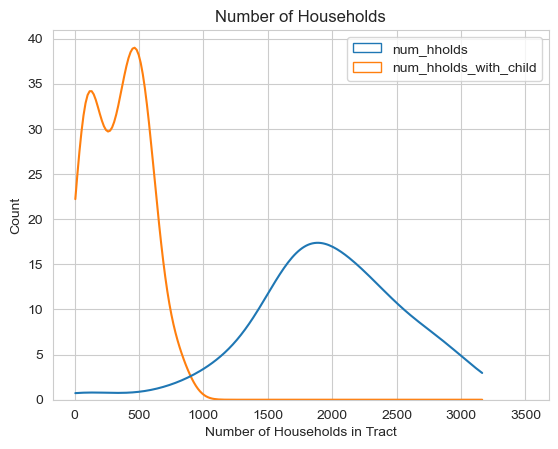

In [97]:
sns.set_style('whitegrid')

ax = sns.histplot(data = data_households[['num_hholds', 'num_hholds_with_child']], fill = False, kde = True, binwidth = 500)
ax.containers[0].remove()
ax.containers[0].remove()
ax.set_title('Number of Households');
ax.set_xlabel('Number of Households in Tract');

#### (b) Join datasets

Join the `data_agg` DataFrame and the household data using `geo_id`. Note that we will duplicate the data on households for each `geo_id` across the years in `data_agg`. Name the resulting dataset `data_reg`. What are the dimensions of `data_reg`?

In [99]:
data_agg.shape, data_households.shape

((150, 8), (50, 3))

In [101]:
data_reg = data_agg.merge(data_households, on = 'geo_id')

In [103]:
data_reg.head()

,geo_id,year,num_crimes,pop_18_24,pop_25_over,ed_high_sch_grad_higher_25_over,ed_bach_deg_grad_higher_25_over,high_sch_grad_prop,coll_grad_pop,num_hholds,num_hholds_with_child
0,1400000US53033000202,2016,584,228,3194,2938,1910,0.919850,0.597996,1651,450
1,1400000US53033000202,2017,626,228,3194,2938,1910,0.919850,0.597996,1651,450
2,1400000US53033000202,2018,590,228,3194,2938,1910,0.919850,0.597996,1651,450
3,1400000US53033000602,2016,637,312,2837,2575,1349,0.907649,0.475502,1682,381
4,1400000US53033000602,2017,588,312,2837,2575,1349,0.907649,0.475502,1682,381


In [105]:
data_reg.shape

(150, 11)

## Problem 4: Regression

#### (a) Simple linear regression

Use the `data_reg` data and the following explanatory variables to fit simple linear regression models to predict the number of crimes in a tract: 

- year
- pop_18_24	
- pop_25_over
- ed_high_sch_grad_higher_25_over	
- ed_bach_deg_grad_higher_25_over	
- high_sch_grad_prop	
- coll_grad_prop	
- num_hholds	
- num_hholds_with_child

In which of the models is there a statistically significant association between the predictor and the response? Why do you think this is?

HINT: It may help to iterate using a for loop and storing the results from each model. Then, you can combine the results from each model to examine/compare. 

In [109]:
x = sm.add_constant(data_reg.drop(['num_crimes', 'geo_id'], axis = 1))
y = data_reg.num_crimes

In [111]:
x.columns

Index(['const', 'year', 'pop_18_24', 'pop_25_over',
       'ed_high_sch_grad_higher_25_over', 'ed_bach_deg_grad_higher_25_over',
       'high_sch_grad_prop', 'coll_grad_pop', 'num_hholds',
       'num_hholds_with_child'],
      dtype='object')

In [117]:
coefs = []
for each in x.columns:
    model = sm.OLS(y, x[each]).fit()
    coef = model.params.values[0]
    conf_int_low = model.conf_int()[0].values[0]
    conf_int_high = model.conf_int()[1].values[0]
    pvalue = model.pvalues.values[0]
    coefs.append((each, coef, pvalue, conf_int_low, conf_int_high))

In [121]:
coefs = pd.DataFrame(coefs, columns = ['param', 'coef', 'pvalue', 'conf_int_low', 'conf_int_high'])
coefs['ci'] = coefs.coef - coefs.conf_int_low

In [123]:
coefs

,param,coef,pvalue,conf_int_low,conf_int_high,ci
0,const,763.840000,2.742763e-68,716.375425,811.304575,47.464575
1,year,0.378701,2.742294e-68,0.355169,0.402233,0.023532
2,pop_18_24,0.603739,4.872793e-13,0.453236,0.754241,0.150503
3,pop_25_over,0.212662,1.245568e-48,0.193551,0.231773,0.019111
4,ed_high_sch_grad_higher_25_over,0.225000,6.173018e-50,0.205303,0.244698,0.019697
5,ed_bach_deg_grad_higher_25_over,0.319130,2.497723e-47,0.289683,0.348576,0.029447
6,high_sch_grad_prop,813.442995,2.191659e-71,765.577069,861.308921,47.865926
7,coll_grad_pop,1167.286951,1.387964e-67,1093.840514,1240.733388,73.446437
8,num_hholds,0.356046,1.201552e-54,0.327618,0.384474,0.028428
9,num_hholds_with_child,1.535421,6.524562e-30,1.324180,1.746662,0.211241


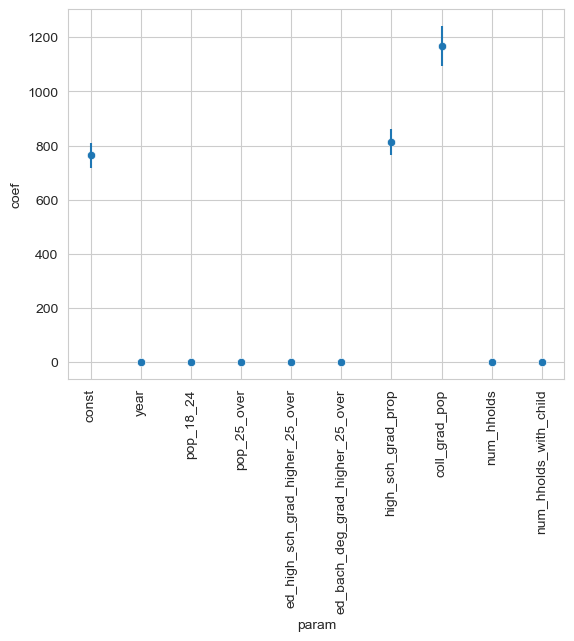

In [125]:
ax = sns.scatterplot(data = coefs, x = 'param', y = 'coef', )
plt.errorbar(data= coefs, x = 'param', y = 'coef', yerr = 'ci', linestyle = 'None')

plt.xticks(rotation=90);

All variables were deemted to be statistically significant.  This is not surprising, given that these are simple regression models.  As we develop more complex models, the coefficients for these models will change and many will no longer be statistically significant to a meaningful degree.

#### (b) Multiple regression

Fit a multiple regression model to predict the response using all of the predictors from the previous section. Describe your results. For which predictors can we reject the null hypothesis $H_0: \beta_j = 0$? Are these the same from the previous section? Explain what may be going on.

In [128]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             num_crimes   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     4.848
Date:                Sat, 17 Aug 2024   Prob (F-statistic):           1.20e-05
Time:                        00:32:21   Log-Likelihood:                -1044.6
No. Observations:                 150   AIC:                             2109.
Df Residuals:                     140   BIC:                             2139.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                            1899.7945   5.35e+04      0.036      0.972   -1.04e+05    1.08e+05
year                                0.5800     26.500      0.022      0.983     -51.811      52.971
pop_18_24                          -0.0386      0.046     -0.830      0.408      -0.131       0.053
pop_25_over                        -1.1098      0.416     -2.671      0.008      -1.931      -0.288
ed_high_sch_grad_higher_25_over     1.7377      0.523      3.321      0.001       0.703       2.772
ed_bach_deg_grad_higher_25_over    -0.7267      0.219     -3.316      0.001      -1.160      -0.293
high_sch_grad_prop              -3904.0608   1756.751     -2.222      0.028   -7377.251    -430.871
coll_grad_pop                    2449.7761    751.817      3.258      0.001     963.394    3936.158
num_hholds                         -0.1154      0.090     -1.277      0.204      -0.294       0.063
num_hholds_with_child              -0.4567      0.194     -2.350      0.020      -0.841      -0.072
==============================================================================
Omnibus:                       32.370   Durbin-Watson:                   0.837
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.605
Skew:                           1.046   Prob(JB):                     1.39e-12
Kurtosis:                       5.087   Cond. No.                     1.45e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Most of the variables were still statistically significant except year, pop_18_24, and num_hholds.  As we've increased our model's complexity, it's also changed the extent to which otherwise unimportant variables contributed to our model fit to a meaningful degree.  Another aspect to consider could also be collinearity - an explanatory variable that is not statistically significant may still have a meaningful association with the response variable but is correlated with other explanatory variables, thereby diminishing the degree to which it's noted as being statistically significant in the larger model.

#### (c) Interpret relationships

For each of the variables in the multivariate regression model, interpret the relationship between the explanatory variable and the response variable based on the calculated coefficient. Do the relationships make sense to you? What are possible explanations about the observed coefficients?

Student response may vary but should address the positive / negative relationships between coefficients and response variable.

#### (d) What about duplication?

Though we had crime incident data for each individual year, we duplicated the census and household data for each tract across each year. As such, we assumed that these measures can be assumed to be constant for each tract across the years examined. What are some potential downsides to doing so?

Bias, overfitting and potentially higher multicollinearity.

#### (e) Examine residuals

Plot the residuals for the multiple regression model for each of the following as the x-axis: `year`, `ed_high_sch_grad_higher_25_over`, `coll_grad_prop`. Comment on what you see.

In [136]:
residuals = model.resid

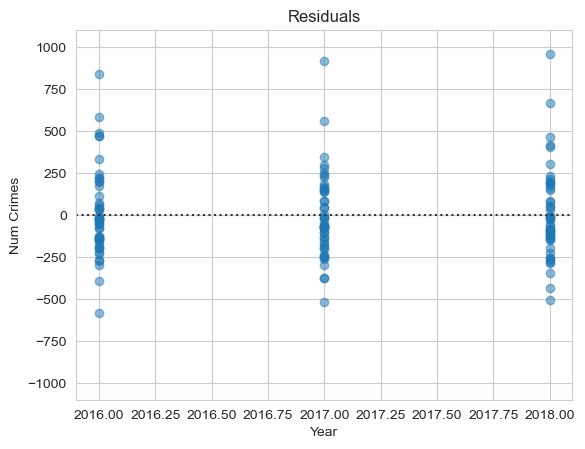

In [138]:
ax = sns.residplot(x = "year", y = residuals, data = data_reg, scatter_kws=dict(alpha=0.5))

ax.set_ylim([-1100, 1100])
ax.set_title('Residuals');
ax.set_xlabel('Year');
ax.set_ylabel('Num Crimes');

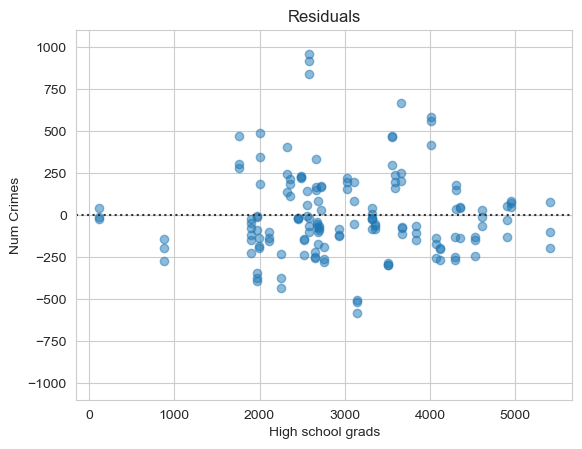

In [140]:
ax = sns.residplot(x = "ed_high_sch_grad_higher_25_over", y = residuals, data = data_reg, scatter_kws=dict(alpha=0.5))

ax.set_ylim([-1100, 1100])
ax.set_title('Residuals');
ax.set_xlabel('High school grads');
ax.set_ylabel('Num Crimes');

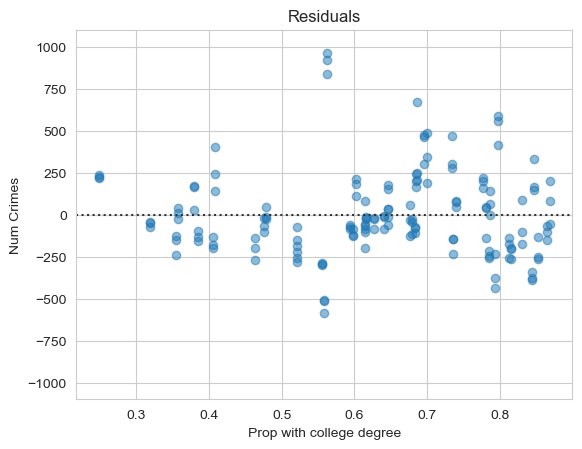

In [144]:
ax = sns.residplot(x = "coll_grad_pop", y = residuals, data = data_reg, scatter_kws=dict(alpha=0.5))

ax.set_ylim([-1100, 1100])
ax.set_title('Residuals');
ax.set_xlabel('Prop with college degree');
ax.set_ylabel('Num Crimes');

There is an obvious pattern with the residuals vs year but that is expected because the data is discrete.  Beyond that, there is no obvious patterns with the residuals.

#### (f) Thinking critically

Amidst data features like population are features like educational attainment per tract. This brings to light the fact that there may be specific demographic and socioeconomic variables/characteristics that are also associated with educational attainment. Whether intentional or not, someone looking at this data might infer a link between crime and educational attainment just due to the variables present. Even worse, someone might use the data to support harsh policing policies based on specific demographics or socioeconomic variables. Discuss, in a few paragraphs, how such datasets could be used (1) in a harmful way, and (2) in a beneficial way for society.

When datasets include demographic and socioeconomic features like educational attainment, population, and income, there’s a risk of misuse that can reinforce harmful stereotypes and policies. For example, if data shows a correlation between low educational attainment and higher crime rates, it might mistakenly be seen as proof that those with less education are more prone to criminal behavior. This could lead to biased policies, such as increased surveillance or harsher policing in areas with lower educational attainment.

However, when used wisely, these datasets can reveal insights that drive positive social change. Identifying correlations between low educational attainment and crime can highlight the need for targeted interventions, such as improving educational opportunities in underserved communities. Policymakers can use this information to fund programs that address root causes of crime, like poverty and lack of access to quality education.

While there is potential for misuse that could lead to biased policies, these datasets also hold significant potential for promoting equity if interpreted carefully and applied with a focus on social justice.